## Install some libraries

In [1]:
!pip install tensorflow pandas scikit-learn yfinance

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf

pd.set_option('display.max_columns',None)

## User defined functions

In [3]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

## Load the data

In [4]:
sgx = pd.read_csv('/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/Data/Results_Sentiment_gold_Price.csv')
sgx.head()

,Dates,News,sentiment,probabilities
0,13-09-2017,gold suffers third straight daily decline,neutral,[0.02663359 0.9320141 0.04135231]
1,28-02-2018,dent research : is gold's day in the sun comin...,positive,[0.05900801 0.02633485 0.9146572 ]
2,06-09-2017,"Gold snaps three-day rally as Trump, lawmakers...",negative,[0.4886155 0.22143883 0.28994563]
3,16-03-2018,"april gold holds slight gain, up $2.50, or 0.2...",negative,[0.93694174 0.03632999 0.02672821]
4,28-07-2017,gold trades in red in early trade; eyes near-t...,negative,[0.51928973 0.09720761 0.38350272]


In [5]:

df_sgx              = sgx[['Dates','sentiment']].rename(columns = {'Dates': 'Date'} )
sen_le              = LabelEncoder()
df_sgx['sentiment'] = sen_le.fit_transform(df_sgx['sentiment'])
df_sgx['Date']      = pd.to_datetime(df_sgx['Date'], format='%d-%m-%Y')
df_sgx['Date']      = pd.to_datetime(df_sgx['Date'], format='%Y-%m-%d')
df_sgx

,Date,sentiment
0,2017-09-13,1
1,2018-02-28,2
2,2017-09-06,0
3,2018-03-16,0
4,2017-07-28,0
...,...,...
3429,2017-06-08,1
3430,2018-11-22,1
3431,2017-06-30,1
3432,2018-09-27,2


In [6]:

# df_sgx = sgx[['Date','Open']].rename(columns={'Open':'gift_open'})

# # Convert 'Date' to datetime format (considering it's in 'dd-mm-yyyy' format)
# df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%d-%m-%Y')

# # Remove commas from the 'Open' column and convert to float
# df_sgx['gift_open'] = df_sgx['gift_open'].replace({',': ''}, regex=True).astype(float)
# df_sgx['Date'] = pd.to_datetime(df_sgx['Date'], format='%Y-%m-%d')

# df_sgx['gift_open'] = df_sgx['gift_open'].shift(1)


# # Check the updated dataframe
# print(df_sgx.tail())




In [7]:
#df_train_all    = pd.read_csv('data/SPX.csv')

start_date = "2017-01-01"
end_date   = "2019-03-31"

data = yf.download("GC=F", start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0) # from multi index to single index

data = data.reset_index()


print(data.head())



[*********************100%***********************]  1 of 1 completed

Price                      Date    Adj Close        Close         High  \
0     2017-01-03 00:00:00+00:00  1160.400024  1160.400024  1160.800049   
1     2017-01-04 00:00:00+00:00  1163.800049  1163.800049  1165.000000   
2     2017-01-05 00:00:00+00:00  1179.699951  1179.699951  1183.300049   
3     2017-01-06 00:00:00+00:00  1171.900024  1171.900024  1176.500000   
4     2017-01-09 00:00:00+00:00  1183.500000  1183.500000  1183.599976   

Price          Low         Open  Volume  
0      1146.500000  1155.199951      52  
1      1156.300049  1156.300049      36  
2      1171.500000  1172.000000     500  
3      1171.900024  1176.500000      16  
4      1173.000000  1173.900024      62  


In [8]:
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [9]:

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date']).dt.date
#data.set_index('Date', inplace=True)


df_train_all = data.copy()


In [10]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'], format='%Y-%m-%d')


df_train_all         = df_train_all.merge(df_sgx, how = 'left', on = 'Date' )
df_train_all.head()


,Date,Adj Close,Close,High,Low,Open,Volume,sentiment
0,2017-01-03,1160.400024,1160.400024,1160.800049,1146.5,1155.199951,52,1.0
1,2017-01-03,1160.400024,1160.400024,1160.800049,1146.5,1155.199951,52,1.0
2,2017-01-03,1160.400024,1160.400024,1160.800049,1146.5,1155.199951,52,0.0
3,2017-01-03,1160.400024,1160.400024,1160.800049,1146.5,1155.199951,52,0.0
4,2017-01-03,1160.400024,1160.400024,1160.800049,1146.5,1155.199951,52,0.0


In [11]:
df_train_all['sentiment'] = df_train_all['sentiment'].fillna(method='ffill')

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_23017/637754392.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train_all['sentiment'] = df_train_all['sentiment'].fillna(method='ffill')


## Feature engineering

In [12]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()

df_train_all.dropna(subset=['100DMA'], inplace=True)

In [13]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [14]:
df_train_all.columns


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'sentiment', '10DMA', '30DMA', '100DMA'],
      dtype='object')

In [15]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])


df_train_all['day'] = df_train_all['Date'].dt.strftime("%A")
le_day = LabelEncoder()
df_train_all['day'] = le_day.fit_transform(df_train_all['day'])

df_train_all['date_no'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


In [16]:


# Convert month and day to cyclical features
#df_train_all['month_sin'] = np.sin(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['month_cos'] = np.cos(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['day_sin'] = np.sin(2 * np.pi * df_train_all['day'] / 31)
#df_train_all['day_cos'] = np.cos(2 * np.pi * df_train_all['day'] / 31)



In [17]:
df_train_all['next_close'] = df_train_all['Close'].shift(-1)
df_train_all['target'] = df_train_all['next_close'] - df_train_all['Close']
df_train_all.dropna(subset=['target'], inplace=True)

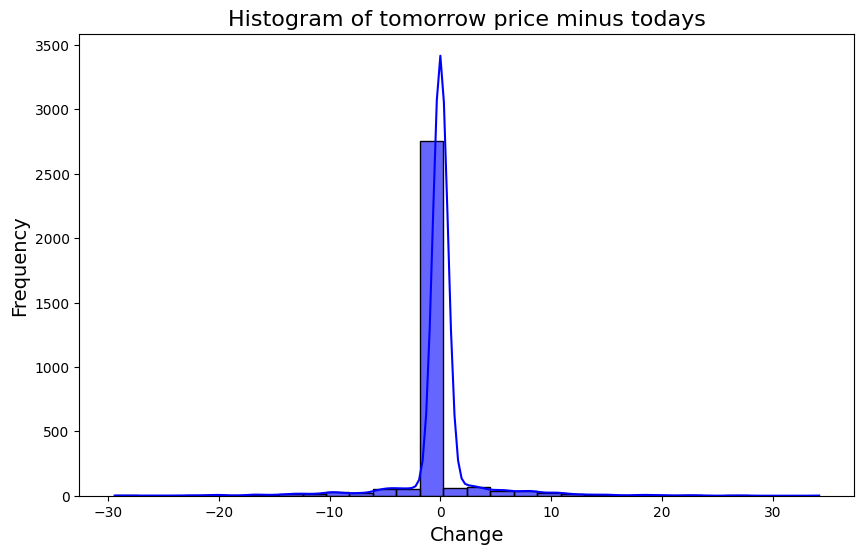

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_train_all['target'].dropna(), bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [19]:
skewness = df_train_all['target'].skew()
print(f"Skewness of target: {skewness}")


Skewness of target: 0.14064400027495802


### Show how min max transform will preserve the original distribution

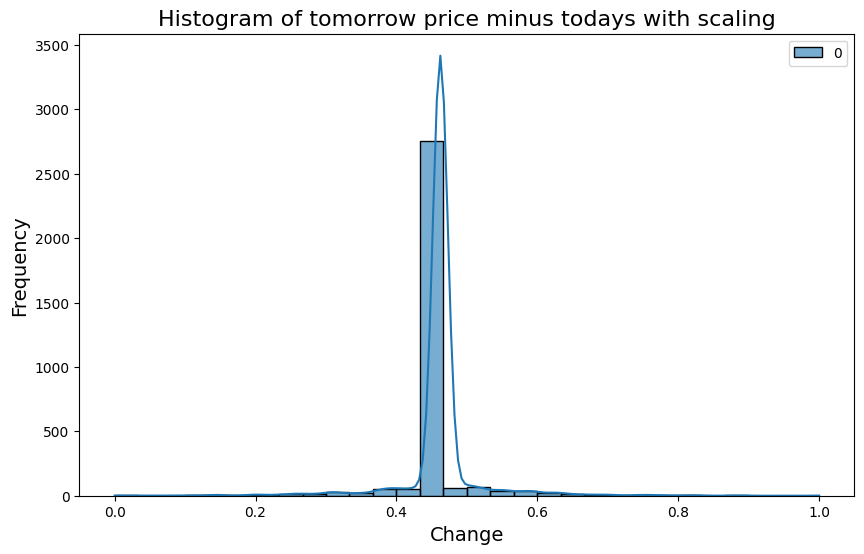

In [20]:
mm = MinMaxScaler()
ss = mm.fit_transform(df_train_all[['target']])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays with scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

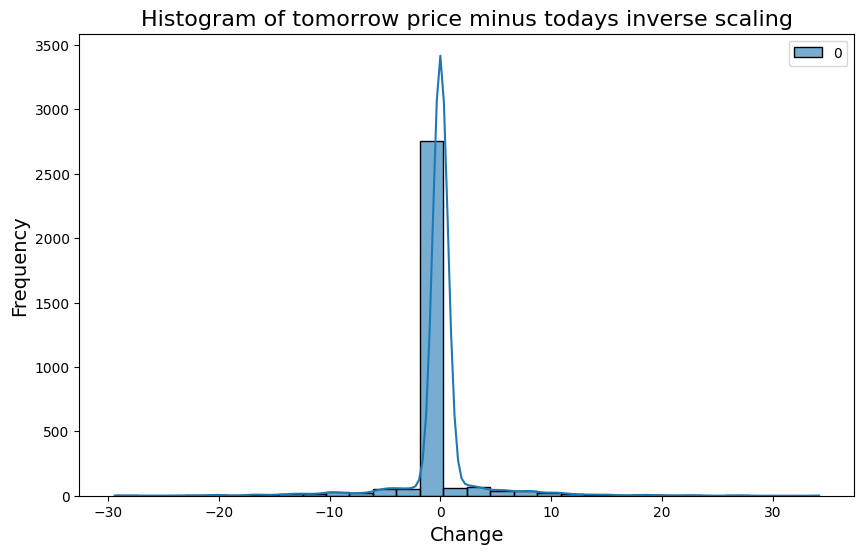

In [21]:
ss_inv = mm.inverse_transform(ss)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(ss_inv, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of tomorrow price minus todays inverse scaling', fontsize=16)
plt.xlabel('Change', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

### Back on route

In [22]:
df_train_all.head()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target
99,2017-01-20,1204.300049,1204.300049,1212.099976,1202.800049,1202.800049,38,2.0,1201.920032,1207.713359,1189.784014,0,20,1,0,0,1204.300049,0.000000
100,2017-01-20,1204.300049,1204.300049,1212.099976,1202.800049,1202.800049,38,0.0,1202.260034,1207.456694,1190.223014,0,20,1,0,0,1204.300049,0.000000
101,2017-01-20,1204.300049,1204.300049,1212.099976,1202.800049,1202.800049,38,2.0,1202.600037,1207.200028,1190.662014,0,20,1,0,0,1204.300049,0.000000
102,2017-01-20,1204.300049,1204.300049,1212.099976,1202.800049,1202.800049,38,0.0,1202.940039,1206.943363,1191.101014,0,20,1,0,0,1215.000000,10.699951
103,2017-01-23,1215.000000,1215.000000,1215.000000,1210.000000,1212.000000,16,0.0,1204.350037,1207.043363,1191.647014,1,23,1,0,0,1215.000000,0.000000


In [23]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
df_train_all['prev_close'] = df_train_all['Close'].shift(1)

df_train_all['pct_change_in_a_day'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['act_change_in_a_day'] = df_train_all['Close']-df_train_all['Open']
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
#df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
df_train_all['range_avg'] =  df_train_all['daily_move'].rolling(window=5).mean() #average of last 5 day movement
df_train_all['change_avg'] =  df_train_all['act_change_in_a_day'].rolling(window=5).mean()
#df_train_all['price_lag2'] = df_train_all['Adj Close'].shift(2)
#df_train_all['price_lag3'] = df_train_all['Adj Close'].shift(3)
#df_train_all['price_lag4'] = df_train_all['Adj Close'].shift(4)
#df_train_all['price_lag5'] = df_train_all['Adj Close'].shift(5)
#df_train_all.dropna(subset=['price_lag5'], inplace=True)

In [24]:
df_train_all.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
3332,2019-03-22,1311.599976,1311.599976,1311.599976,1311.599976,1311.599976,0,2.0,1301.130017,1307.546676,1283.669000,0,22,3,2,0,1321.900024,10.300049,1306.099976,1.000000,0.000000,5.500000,0.000000,1.439966,0.180005
3333,2019-03-25,1321.900024,1321.900024,1322.900024,1320.699951,1320.699951,19,2.0,1304.440015,1307.820011,1284.451001,1,25,3,2,0,1314.300049,-7.599976,1311.599976,1.000909,1.200073,9.099976,2.200073,0.900000,-0.179980
3334,2019-03-26,1314.300049,1314.300049,1315.599976,1314.300049,1315.599976,1,2.0,1306.240015,1308.063346,1285.175001,3,26,3,2,0,1309.900024,-4.400024,1321.900024,0.999012,-1.299927,-6.300049,1.299927,0.739990,-0.059961
3335,2019-03-27,1309.900024,1309.900024,1309.900024,1309.900024,1309.900024,206263,2.0,1306.480017,1308.086682,1285.855001,4,27,3,2,0,1289.800049,-20.099976,1314.300049,1.000000,0.000000,-4.400024,0.000000,0.700000,-0.019971
3336,2019-03-28,1289.800049,1289.800049,1311.099976,1287.699951,1308.400024,87798,2.0,1306.120020,1307.386682,1286.309001,2,28,3,2,1,1293.000000,3.199951,1309.900024,0.985784,-18.599976,-1.500000,23.400024,5.380005,-3.739966


In [25]:
split_date   = '2018-10-30'

df_train = df_train_all[df_train_all['Date']<=  split_date] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  split_date] #keeping last year for testing

In [26]:
df_lstm_results  = pd.DataFrame()

In [27]:
df_test.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,sentiment,10DMA,30DMA,100DMA,day,date_no,month,year,opt_exp,next_close,target,prev_close,pct_change_in_a_day,act_change_in_a_day,opening_gap,daily_move,range_avg,change_avg
3332,2019-03-22,1311.599976,1311.599976,1311.599976,1311.599976,1311.599976,0,2.0,1301.130017,1307.546676,1283.669000,0,22,3,2,0,1321.900024,10.300049,1306.099976,1.000000,0.000000,5.500000,0.000000,1.439966,0.180005
3333,2019-03-25,1321.900024,1321.900024,1322.900024,1320.699951,1320.699951,19,2.0,1304.440015,1307.820011,1284.451001,1,25,3,2,0,1314.300049,-7.599976,1311.599976,1.000909,1.200073,9.099976,2.200073,0.900000,-0.179980
3334,2019-03-26,1314.300049,1314.300049,1315.599976,1314.300049,1315.599976,1,2.0,1306.240015,1308.063346,1285.175001,3,26,3,2,0,1309.900024,-4.400024,1321.900024,0.999012,-1.299927,-6.300049,1.299927,0.739990,-0.059961
3335,2019-03-27,1309.900024,1309.900024,1309.900024,1309.900024,1309.900024,206263,2.0,1306.480017,1308.086682,1285.855001,4,27,3,2,0,1289.800049,-20.099976,1314.300049,1.000000,0.000000,-4.400024,0.000000,0.700000,-0.019971
3336,2019-03-28,1289.800049,1289.800049,1311.099976,1287.699951,1308.400024,87798,2.0,1306.120020,1307.386682,1286.309001,2,28,3,2,1,1293.000000,3.199951,1309.900024,0.985784,-18.599976,-1.500000,23.400024,5.380005,-3.739966


In [28]:
df_train.dropna(subset=['range_avg'], inplace=True)
#df_train.dropna(subset=['gift_open'], inplace=True)
df_train.columns

/var/folders/ws/v15jk6j56z90j1tz393rgysw0000gn/T/ipykernel_23017/3666865507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(subset=['range_avg'], inplace=True)


Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'sentiment', '10DMA', '30DMA', '100DMA', 'day', 'date_no', 'month',
       'year', 'opt_exp', 'next_close', 'target', 'prev_close',
       'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
       'daily_move', 'range_avg', 'change_avg'],
      dtype='object')

In [29]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume',
                    'sentiment', '10DMA', '30DMA', '100DMA', 'day', 'date_no',
                    'pct_change_in_a_day', 'act_change_in_a_day', 'opening_gap',
                    'daily_move', 'range_avg', 'change_avg']

features_to_scale = [ 'Close', 'sentiment']


# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

df[features_to_scale].head()

,Close,sentiment
103,1215.0,0.0
104,1215.0,2.0
105,1215.0,0.0
106,1215.0,1.0
107,1215.0,0.0


In [30]:

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'target'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

#X_train = df[features]
#y_train = df[target]
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

print("X_train_reshaped shape:", X_train_scaled.shape)
print("y_train_reshaped shape:", y_train_scaled.shape)
print("X_test_reshaped shape:", X_test_scaled.shape)
print("y_test_reshaped shape:", y_test_scaled.shape)



X_train_reshaped shape: (2372, 3)
y_train_reshaped shape: (2372, 1)
X_test_reshaped shape: (593, 3)
y_test_reshaped shape: (593, 1)


In [31]:

timesteps = 60



In [32]:

# Function to create sequences for LSTM
def create_sequences(data, target, timesteps):
    sequences = []
    targets = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i+timesteps, :])
        targets.append(target[i+timesteps-1])  # Use the last value in the window as the target
    return np.array(sequences), np.array(targets)

# Create LSTM-compatible sequences
X_train_reshaped, y_train_reshaped = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train_reshaped shape:", y_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)



X_train_reshaped shape: (2313, 60, 3)
y_train_reshaped shape: (2313, 1)
X_test_reshaped shape: (534, 60, 3)
y_test_reshaped shape: (534, 1)


In [33]:

# Build your LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2]))))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.1))
model.add(Dense(25))
model.add(Dropout(0.1))

model.add(Dense(1))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])

# Train the model
history = model.fit(X_train_reshaped, 
                    y_train_reshaped, 
                    epochs=100, 
                    validation_data=(X_test_reshaped, y_test_reshaped), 
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/100


/opt/anaconda3/envs/Conda_3_12_7/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0265 - mae: 0.1175 - mse: 0.0265 - val_loss: 0.0059 - val_mae: 0.0478 - val_mse: 0.0059
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0059 - mae: 0.0511 - mse: 0.0059 - val_loss: 0.0046 - val_mae: 0.0295 - val_mse: 0.0046
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 0.0059 - mae: 0.0484 - mse: 0.0059 - val_loss: 0.0045 - val_mae: 0.0283 - val_mse: 0.0045
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - loss: 0.0053 - mae: 0.0453 - mse: 0.0053 - val_loss: 0.0049 - val_mae: 0.0347 - val_mse: 0.0049
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 0.0052 - mae: 0.0451 - mse: 0.0052 - val_loss: 0.0046 - val_mae: 0.0284 - val_mse: 0.0046
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0056 - mae: 0.0469 - mse: 0.0056 - val_loss: 0.0046 - val_mae: 0.0277 - val_mse: 0.0046
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 0.0049 - mae: 0.0414 - mse: 0.0049 - val_

In [34]:

##############################################################################################
#########################          Checking val performance              #############################
##############################################################################################


# Predictions
lstm_predictions = model.predict(X_test_reshaped)
lstm_predictions = lstm_predictions.reshape(-1,1)

# Ensure both predictions and actual values are of type float64
y_test_reshaped = y_test_reshaped.reshape(-1, 1).astype('float64')
lstm_predictions_scaled = lstm_predictions.astype('float64')


y_test_actual = target_scaler.inverse_transform(y_test_reshaped).astype('float64')
lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')
results_test_unscaled   = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Validation performance: ",results_test_unscaled)

#

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - mae: 0.0248 - mse: 0.0041
Validation performance:  [0.004496525973081589, 0.026090318337082863, 0.004496525973081589]


## Applying model on Test Data

In [35]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()
#df = df_train_all.copy()  #change 1: to make prediction on whole data

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part        = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled             = np.hstack((X_test_scaled_part, df[features_to_leave].values))
#X_test_reshaped           = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

y_test_scaled             = target_scaler.transform(df['target'].values.reshape(-1, 1))


X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Check shapes
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_test_reshaped shape:", y_test_reshaped.shape)


test_performance          = model.evaluate(X_test_reshaped, y_test_reshaped)
print("Test performance (MAE): ", test_performance[1])





X_test_reshaped shape: (210, 60, 3)
y_test_reshaped shape: (210, 1)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0053 - mae: 0.0343 - mse: 0.0053
Test performance (MAE):  0.05444750934839249


In [36]:
model.predict(X_test_reshaped).shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


(210, 1)

In [37]:
df_test.shape[0] - lstm_predictions_actual.shape[0]

-265

In [38]:
# Predictions
lstm_predictions         = model.predict(X_test_reshaped)
lstm_predictions_scaled  = lstm_predictions.astype('float64')

lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')

df_test_prediction      = df_test[(timesteps- 1):].copy() 
#df_test_prediction      = df_train_all[(timesteps- 1):].copy() #change 2: to make prediction on whole data

# Add predictions to the dataframe
df_test_prediction['change_predicted'] = lstm_predictions_actual



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [39]:

df_test_prediction['predicted_close'] = df_test_prediction['Close'] + df_test_prediction['change_predicted']

In [40]:
df_test_prediction.dropna(subset=['predicted_close'], inplace=True)

In [41]:
df_test_prediction['prediction_diff'] =  df_test_prediction['predicted_close']-df_test_prediction['next_close']
df_test_prediction['pct_prediction_diff'] = df_test_prediction['prediction_diff']/df_test_prediction['next_close']*100

df_test_prediction[['next_close','predicted_close','prediction_diff','pct_prediction_diff']]


,next_close,predicted_close,prediction_diff,pct_prediction_diff
3127,1207.900024,1199.362037,-8.537987,-0.706846
3128,1207.900024,1208.112492,0.212468,0.017590
3129,1207.900024,1208.010632,0.110608,0.009157
3130,1207.900024,1207.919532,0.019507,0.001615
3131,1207.900024,1207.956965,0.056941,0.004714
...,...,...,...,...
3332,1321.900024,1310.956525,-10.943499,-0.827861
3333,1314.300049,1321.257775,6.957726,0.529386
3334,1309.900024,1313.773233,3.873208,0.295687
3335,1289.800049,1309.304520,19.504471,1.512209


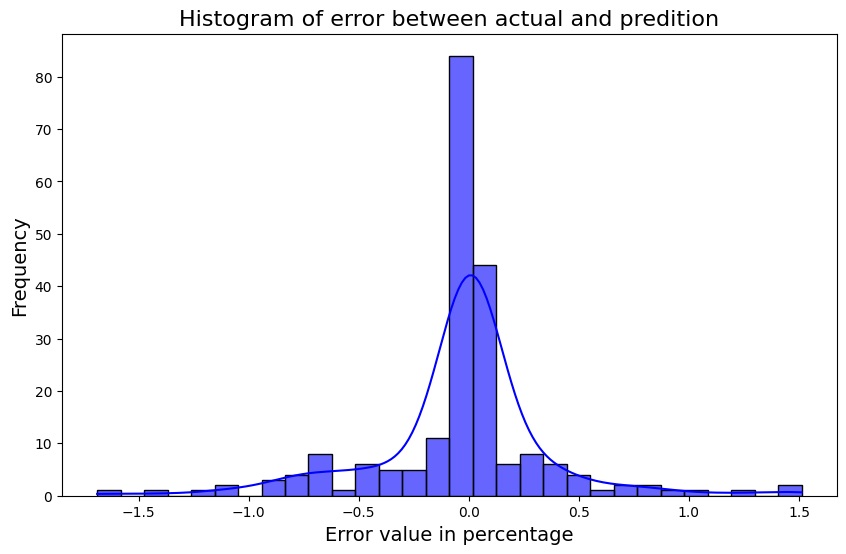

In [42]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_test_prediction['pct_prediction_diff'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of error between actual and predition', fontsize=16)
plt.xlabel('Error value in percentage', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

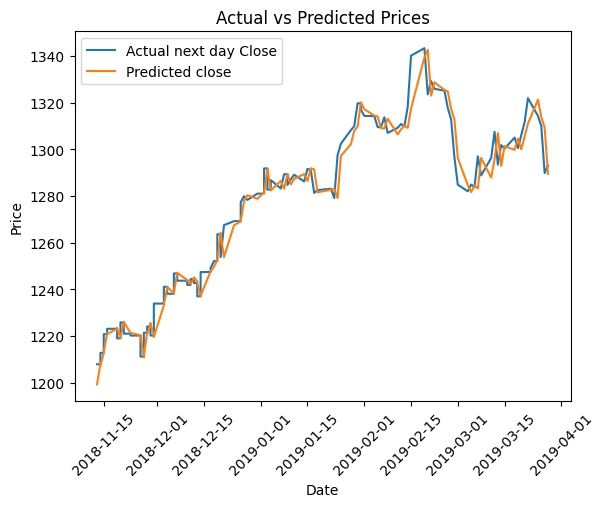

In [43]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['next_close'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['predicted_close'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

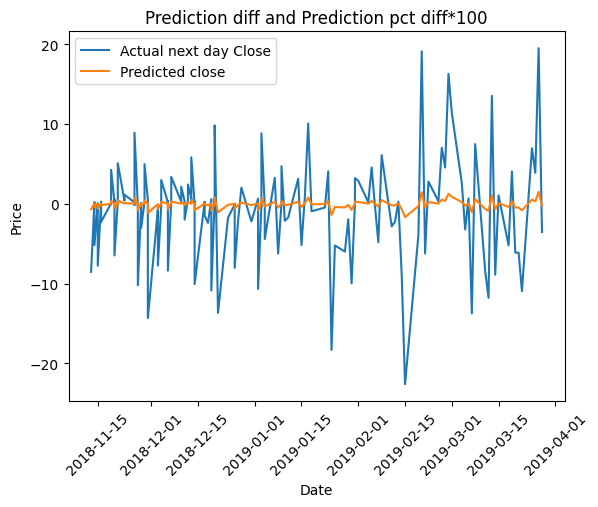

In [44]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test_prediction['Date'], df_test_prediction['prediction_diff'], label='Actual next day Close')
plt.plot(df_test_prediction['Date'], df_test_prediction['pct_prediction_diff'], label='Predicted close')

# Add a title, labels, and legend
plt.title('Prediction diff and Prediction pct diff*100')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [45]:
print("average percentage difference", df_test_prediction['pct_prediction_diff'].abs().mean())
print("average points difference", df_test_prediction['prediction_diff'].abs().mean())

average percentage difference 0.22045258067823909
average points difference 2.820377086093538


In [46]:
needed_columns = ['Date', 'next_close', 'predicted_close', 'prediction_diff', 'pct_prediction_diff']

df_test_sample = df_test_prediction[needed_columns]


# Generate new column names
new_columns = {col: f"{col}_{timesteps}" for col in needed_columns[2:]}

# Rename the columns in the DataFrame (excluding 'Date')
df_test_sample = df_test_sample.rename(columns=new_columns)


In [47]:
save_wip_folder  = '/Users/monilshah/Documents/02_NWU/09_MSDS_458_DL/99_group_project/StockPricePrediction/MSDS_458_Group_N/03_LSTM_timeseries/WIP_files/' 
file_name        = 'predictions_'+str(timesteps) + '.csv'
save_wip         = save_wip_folder + file_name

df_test_sample.to_csv(save_wip)

In [48]:
df_test_sample.head()

,Date,next_close,predicted_close_60,prediction_diff_60,pct_prediction_diff_60
3127,2018-11-13,1207.900024,1199.362037,-8.537987,-0.706846
3128,2018-11-14,1207.900024,1208.112492,0.212468,0.017590
3129,2018-11-14,1207.900024,1208.010632,0.110608,0.009157
3130,2018-11-14,1207.900024,1207.919532,0.019507,0.001615
3131,2018-11-14,1207.900024,1207.956965,0.056941,0.004714


In [49]:
print("Average prediction error :", round(df_test_sample['pct_prediction_diff_60'].abs().mean(),2), "%")

Average prediction error : 0.22 %
